<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/cnn1d_sentiment_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1d CNNs for sentiment classification

We use 1d CNNs for IMDB movie review classification.
Based on sec 15.3 of http://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-cnn.html




In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import collections
import os

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

# Data

We use IMDB dataset. Details in [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/rnn_sentiment_torch.ipynb).

In [2]:
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

# Model

We use 2 embedding layers, one with frozen weights, and one with learnable weights. We feed their concatenation to the 1d CNN. We then do average pooling over time before passing into the final MLP to map to the 2 output logits.


In [3]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no weight, so it can share an
        # instance
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate the output of two embedding layers with shape of
        # (batch size, no. of words, word vector dimension) by word vector
        embeddings = torch.cat(
            (self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # According to the input format required by Conv1d, the word vector
        # dimension, that is, the channel dimension of the one-dimensional
        # convolutional layer, is transformed into the previous dimension
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor with the shape of (batch size, channel size, 1)
        # can be obtained. Use the flatten function to remove the last
        # dimension and then concatenate on the channel dimension
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        # After applying the dropout method, use a fully connected layer to
        # obtain the output
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [4]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

We load pretrained Glove vectors. We use these to initialize the embedding layers, one of which is frozen.


In [5]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# Training

loss 0.067, train acc 0.978, test acc 0.873
1947.5 examples/sec on [device(type='cuda', index=0)]


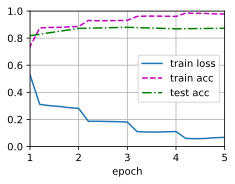

In [6]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# Testing

In [7]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [8]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'